In [ ]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

!pip install gensim==4.3.2
# 의존성 연결을 위해 다운그레이드를 진행합니다.
!pip install scipy==1.12.0 numpy==1.26.3

--2025-10-28 01:00:25--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  --.-KB/s    in 0.04s   

2025-10-28 01:00:25 (335 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2025-10-28 01:00:25--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [application/octet-

데이터 로드 → 전처리 → 분석
    \
4개 모델 학습 → 성능 비교
    \
임베딩 분석 (Gensim)
    \
Word2Vec 적용 (Frozen/Fine-tune)
    \
최종 성능 비교 및 시각화 \
SimpleLSTM: 86.32% \
BiLSTM: 86.68% \
TextCNN: 85.45% \
LSTMAttention: 87.11% \
word2vec: 84.78% \
word2vec_FineTune: 87.34% \ 
자체학습 임베딩 벡터 수: 9996
임베딩 차원: 128

[자체학습 임베딩 - 유사 단어 분석]

'재미있'와 유사한 단어:
  - 문자: 0.3511
  - 스트립: 0.3182
  - 먹먹해: 0.3080
  - 숙제: 0.2976
  - 고소: 0.2923

'감동'와 유사한 단어:
  - 숨: 0.3160
  - 교차: 0.3014
  - 돠: 0.2976
  - 따: 0.2905
...
  Word2Vec: ['가수', '성악가', '무용가']

Word2Vec 커버리지: 9457/10000 (94.57%)
Embedding Matrix Shape: (10000, 100)

In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 45.3 MB/s eta 0:00:00
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91 (from 1)
Receiving objects: 100% (138/138), 1.72 MiB | 54.89 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-10-28 01:02:24--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.134, 13.200.41.135, 13.200.41.136, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.134|:443... connected.
HTTP request sent, awai

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from konlpy.tag import Mecab
import gensim
from gensim.models import Word2Vec

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

In [ ]:
train_data = pd.read_table('/content/ratings_train.txt')
test_data = pd.read_table('/content/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
train_data = pd.read_table('/content/ratings_train.txt')
test_data = pd.read_table('/content/ratings_test.txt')

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<EOS>', '<UNK>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Vocabulary size: {len(word_to_index)}")

Train samples: 146182
Test samples: 49157
Vocabulary size: 10000


In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 함수 테스트
test_sentence = "이 영화 정말 재미있어요"
encoded = get_encoded_sentence(test_sentence, word_to_index)
decoded = get_decoded_sentence(encoded, index_to_word)
print(f"\n[인코딩/디코딩 테스트]")
print(f"원본: {test_sentence}")
print(f"인코딩: {encoded[:10]}...")  # 처음 10개만
print(f"디코딩: {decoded}")



[인코딩/디코딩 테스트]
원본: 이 영화 정말 재미있어요
인코딩: [1, 3, 5, 29, 3]...
디코딩: <UNK> 영화 정말 <UNK>


/tmp/ipython-input-3501120885.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_lengths, test_lengths], labels=['Train', 'Test'])
/tmp/ipython-input-3501120885.py:33: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3501120885.py:33: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3501120885.py:33: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3501120885.py:33: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3501120885.py:33: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipyt

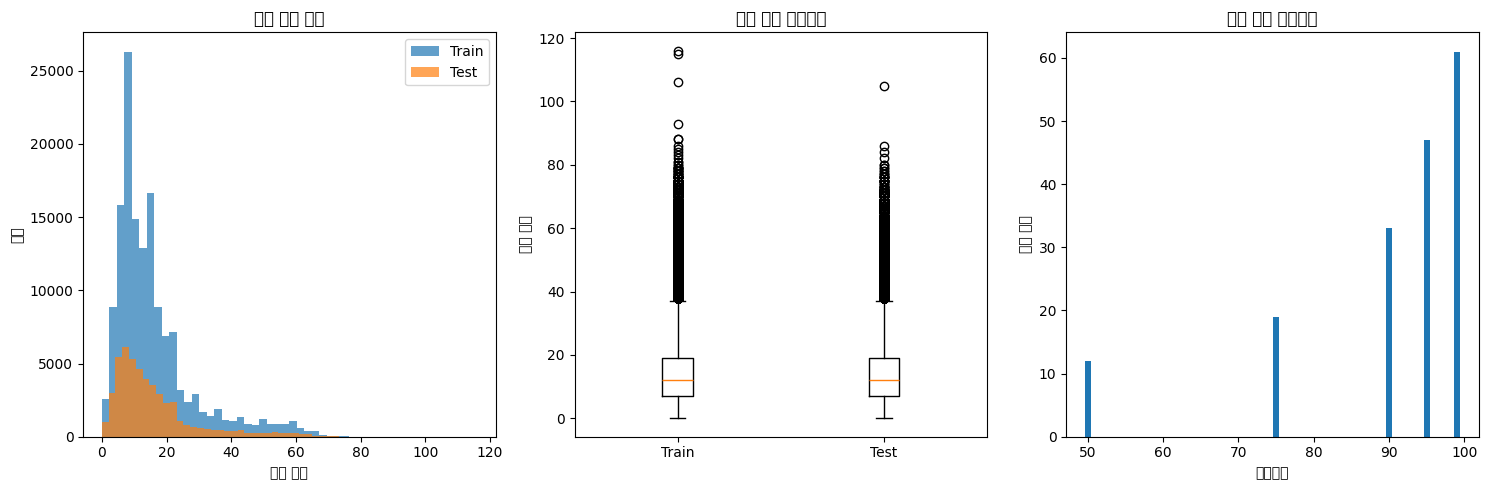

평균 문장 길이 - Train: 15.98, Test: 15.93
최대 문장 길이 - Train: 116, Test: 105
95 백분위 문장 길이 - Train: 47.00

선택된 최대 문장 길이: 47


In [ ]:
# 문장 길이 분포 분석
train_lengths = [len(sentence) for sentence in X_train]
test_lengths = [len(sentence) for sentence in X_test]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_lengths, bins=50, alpha=0.7, label='Train')
plt.hist(test_lengths, bins=50, alpha=0.7, label='Test')
plt.xlabel('문장 길이')
plt.ylabel('빈도')
plt.title('문장 길이 분포')
plt.legend()

plt.subplot(1, 3, 2)
plt.boxplot([train_lengths, test_lengths], labels=['Train', 'Test'])
plt.ylabel('문장 길이')
plt.title('문장 길이 박스플롯')

plt.subplot(1, 3, 3)
percentiles = [50, 75, 90, 95, 99]
train_percentiles = [np.percentile(train_lengths, p) for p in percentiles]
plt.bar(percentiles, train_percentiles)
plt.xlabel('백분위수')
plt.ylabel('문장 길이')
plt.title('문장 길이 백분위수')
plt.tight_layout()
plt.savefig('sentence_length_analysis.png')
plt.show()

print(f"평균 문장 길이 - Train: {np.mean(train_lengths):.2f}, Test: {np.mean(test_lengths):.2f}")
print(f"최대 문장 길이 - Train: {max(train_lengths)}, Test: {max(test_lengths)}")
print(f"95 백분위 문장 길이 - Train: {np.percentile(train_lengths, 95):.2f}")

# 최대 문장 길이 설정 (95 백분위 기준)
MAX_LEN = int(np.percentile(train_lengths, 95))
print(f"\n선택된 최대 문장 길이: {MAX_LEN}")

In [ ]:
class MovieReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.LongTensor(self.X[idx]), torch.LongTensor([self.y[idx]])

def collate_fn(batch):
    """패딩을 추가하는 collate 함수"""
    sequences, labels = zip(*batch)

    # 시퀀스를 MAX_LEN으로 자르거나 패딩
    sequences_padded = []
    for seq in sequences:
        if len(seq) > MAX_LEN:
            sequences_padded.append(seq[:MAX_LEN])
        else:
            sequences_padded.append(seq)

    # pad_sequence 사용
    sequences_padded = pad_sequence(sequences_padded, batch_first=True, padding_value=0)
    labels = torch.cat(labels)

    return sequences_padded, labels


# Train 데이터를 Train/Validation으로 분할
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\nTrain: {len(X_train_split)}, Validation: {len(X_val)}, Test: {len(X_test)}")

# DataLoader 생성
BATCH_SIZE = 64

train_dataset = MovieReviewDataset(X_train_split, y_train_split)
val_dataset = MovieReviewDataset(X_val, y_val)
test_dataset = MovieReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


Train: 116945, Validation: 29237, Test: 49157


In [ ]:

# 모델 1: Simple LSTM

class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super(SimpleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           batch_first=True, dropout=dropout, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        output = self.fc(hidden)
        return output


# 모델 2: Bidirectional LSTM

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        output = self.fc(hidden)
        return output

# 모델 3: CNN for Text Classification

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout=0.3):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, n_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.unsqueeze(1)
        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        output = self.fc(cat)
        return output


# 모델 4: LSTM with Attention

class LSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super(LSTMWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           batch_first=True, dropout=dropout, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out).squeeze(2), dim=1)
        context = torch.sum(attention_weights.unsqueeze(2) * lstm_out, dim=1)

        output = self.fc(self.dropout(context))
        return output


In [ ]:

# 5. 학습 함수

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        predictions = model(batch_x).squeeze(1)
        loss = criterion(predictions, batch_y.float())

        acc = ((torch.sigmoid(predictions) > 0.5).float() == batch_y).float().mean()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            predictions = model(batch_x).squeeze(1)
            loss = criterion(predictions, batch_y.float())

            acc = ((torch.sigmoid(predictions) > 0.5).float() == batch_y).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def train_model(model, train_loader, val_loader, criterion, optimizer, device, n_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')

        print(f'Epoch {epoch+1}/{n_epochs}')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')
        print('-' * 50)

    return train_losses, val_losses, train_accs, val_accs

In [ ]:

# 6. 모델 학습 및 비교

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

VOCAB_SIZE = len(word_to_index)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_EPOCHS = 10

# 모델들 정의
models_dict = {
    'SimpleLSTM': SimpleLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM),
    'BiLSTM': BiLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM),
    'TextCNN': TextCNN(VOCAB_SIZE, EMBEDDING_DIM, 100, [3, 4, 5], OUTPUT_DIM),
    'LSTMAttention': LSTMWithAttention(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
}

results = {}

# 각 모델 학습
for model_name, model in models_dict.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, N_EPOCHS
    )

    # 테스트 평가
    model.load_state_dict(torch.load('best_model.pt'))
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    results[model_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_acc': test_acc
    }

    print(f"\n{model_name} Test Accuracy: {test_acc*100:.2f}%")


Using device: cuda

Training SimpleLSTM
Epoch 1/10
Train Loss: 0.6930 | Train Acc: 50.59%
Val Loss: 0.6932 | Val Acc: 50.17%
--------------------------------------------------
Epoch 2/10
Train Loss: 0.6932 | Train Acc: 50.12%
Val Loss: 0.6932 | Val Acc: 49.83%
--------------------------------------------------
Epoch 3/10
Train Loss: 0.6827 | Train Acc: 52.55%
Val Loss: 0.5482 | Val Acc: 73.90%
--------------------------------------------------
Epoch 4/10
Train Loss: 0.4507 | Train Acc: 78.93%
Val Loss: 0.3693 | Val Acc: 83.20%
--------------------------------------------------
Epoch 5/10
Train Loss: 0.3603 | Train Acc: 84.11%
Val Loss: 0.3366 | Val Acc: 85.26%
--------------------------------------------------
Epoch 6/10
Train Loss: 0.3236 | Train Acc: 85.97%
Val Loss: 0.3214 | Val Acc: 86.10%
--------------------------------------------------
Epoch 7/10
Train Loss: 0.2988 | Train Acc: 87.22%
Val Loss: 0.3314 | Val Acc: 86.30%
--------------------------------------------------
Epoch 8/

/tmp/ipython-input-2776942224.py:33: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2776942224.py:33: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2776942224.py:33: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2776942224.py:33: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2776942224.py:33: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2776942224.py:33: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2776942224.py:33: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layo

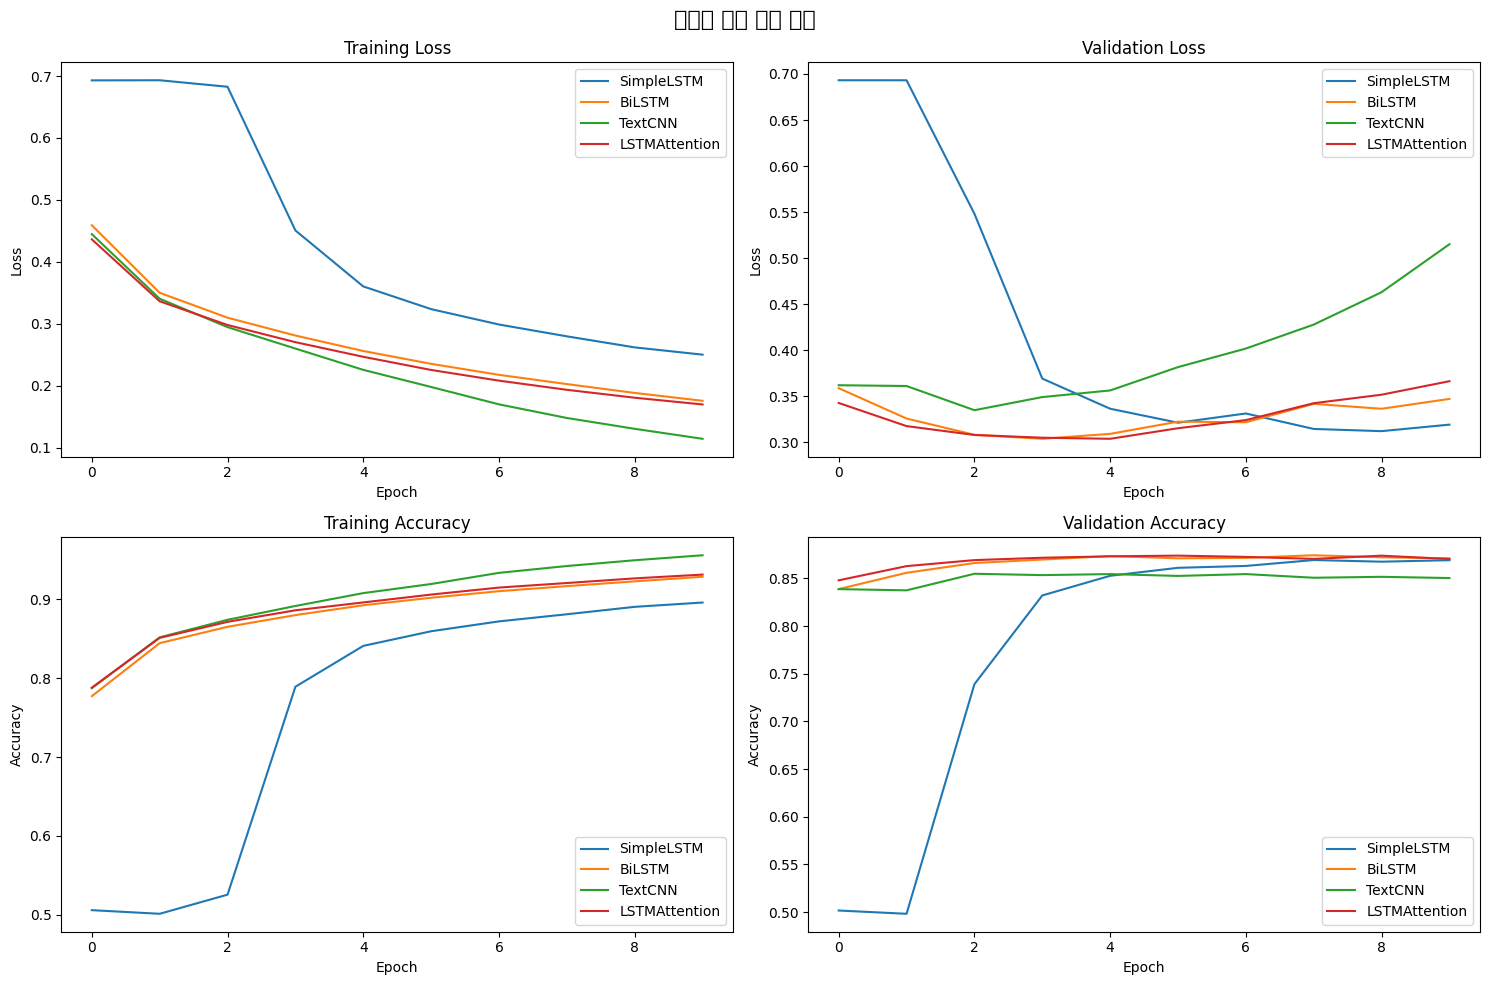

/tmp/ipython-input-2776942224.py:46: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.savefig('test_accuracy_comparison.png')
/tmp/ipython-input-2776942224.py:46: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.savefig('test_accuracy_comparison.png')
/tmp/ipython-input-2776942224.py:46: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.savefig('test_accuracy_comparison.png')
/tmp/ipython-input-2776942224.py:46: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  plt.savefig('test_accuracy_comparison.png')
/tmp/ipython-input-2776942224.py:46: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.savefig('test_accuracy_comparison.png')
/tmp/ipython-input-2776942224.py:46: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.savefig('test_accuracy_compariso

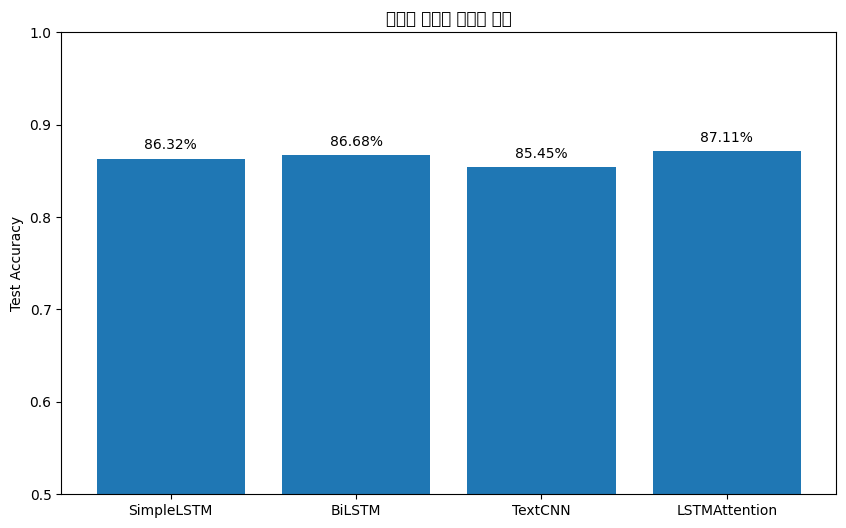

In [ ]:

# 7. Loss, Accuracy 그래프 시각화

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('모델별 학습 결과 비교', fontsize=16)

for model_name, result in results.items():
    axes[0, 0].plot(result['train_losses'], label=model_name)
    axes[0, 1].plot(result['val_losses'], label=model_name)
    axes[1, 0].plot(result['train_accs'], label=model_name)
    axes[1, 1].plot(result['val_accs'], label=model_name)

axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

axes[1, 0].set_title('Training Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# 테스트 정확도 막대 그래프
test_accs = [result['test_acc'] for result in results.values()]
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), test_accs)
plt.ylabel('Test Accuracy')
plt.title('모델별 테스트 정확도 비교')
plt.ylim([0.5, 1.0])
for i, v in enumerate(test_accs):
    plt.text(i, v + 0.01, f'{v*100:.2f}%', ha='center')
plt.savefig('test_accuracy_comparison.png')
plt.show()


/tmp/ipython-input-1417322313.py:30: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.savefig('embedding_visualization.png')
/tmp/ipython-input-1417322313.py:30: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.savefig('embedding_visualization.png')
/tmp/ipython-input-1417322313.py:30: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  plt.savefig('embedding_visualization.png')
/tmp/ipython-input-1417322313.py:30: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.savefig('embedding_visualization.png')
/tmp/ipython-input-1417322313.py:30: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.savefig('embedding_visualization.png')
/tmp/ipython-input-1417322313.py:30: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  plt.savefig('embedding_visualization.png'

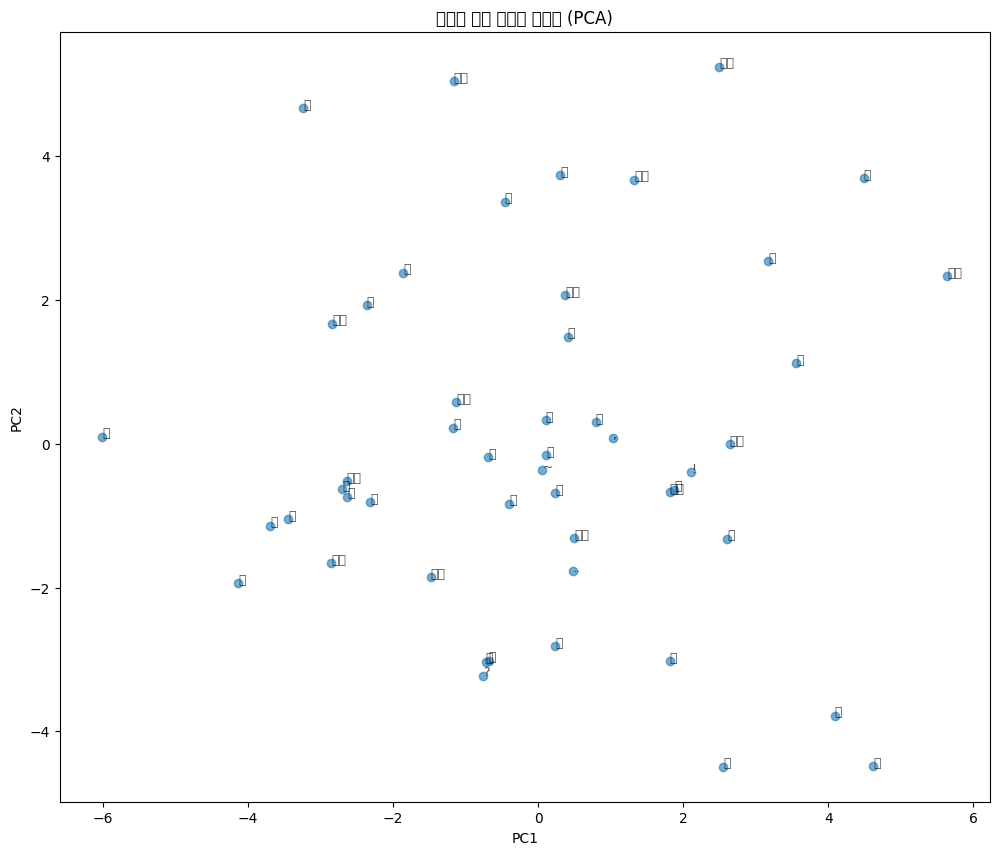

In [ ]:

# 8. 학습된 Embedding 레이어 분석

# 가장 성능이 좋은 모델의 임베딩 분석
best_model_name = max(results, key=lambda x: results[x]['test_acc'])
best_model = models_dict[best_model_name]
best_model.load_state_dict(torch.load('best_model.pt'))

embedding_weights = best_model.embedding.weight.detach().cpu().numpy()

# 임베딩 시각화 (PCA)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 자주 사용되는 단어들의 임베딩 시각화
frequent_words_idx = list(range(10, 60))  # 특수 토큰 제외하고 상위 50개
frequent_embeddings = embedding_weights[frequent_words_idx]

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(frequent_embeddings)

plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
for i, idx in enumerate(frequent_words_idx):
    plt.annotate(index_to_word[idx], (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                fontsize=9, alpha=0.7)
plt.title('학습된 단어 임베딩 시각화 (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('embedding_visualization.png')
plt.show()



Word2Vec 사전 학습 임베딩 적용
Word2Vec Embedding Dimension: 100
Embedding Matrix Shape: (10000, 100)

Training BiLSTM_W2V_Frozen
Epoch 1/10
Train Loss: 0.5278 | Train Acc: 73.47%
Val Loss: 0.4131 | Val Acc: 80.96%
--------------------------------------------------
Epoch 2/10
Train Loss: 0.4506 | Train Acc: 78.48%
Val Loss: 0.3756 | Val Acc: 82.74%
--------------------------------------------------
Epoch 3/10
Train Loss: 0.4228 | Train Acc: 80.13%
Val Loss: 0.3664 | Val Acc: 83.52%
--------------------------------------------------
Epoch 4/10
Train Loss: 0.4088 | Train Acc: 80.98%
Val Loss: 0.3557 | Val Acc: 84.19%
--------------------------------------------------
Epoch 5/10
Train Loss: 0.3979 | Train Acc: 81.61%
Val Loss: 0.3538 | Val Acc: 84.61%
--------------------------------------------------
Epoch 6/10
Train Loss: 0.3911 | Train Acc: 82.03%
Val Loss: 0.3445 | Val Acc: 84.89%
--------------------------------------------------
Epoch 7/10
Train Loss: 0.3843 | Train Acc: 82.42%
Val Loss: 0.

/tmp/ipython-input-2563578565.py:110: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2563578565.py:110: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


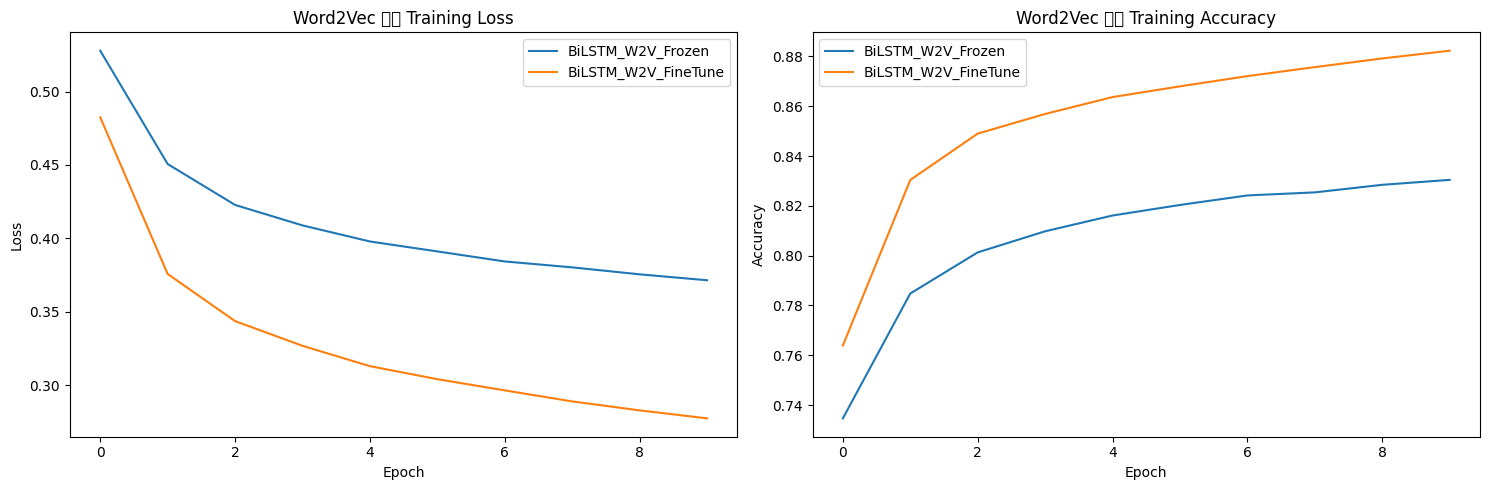

In [ ]:
# ============================================================
# 9. Word2Vec 사전 학습 임베딩 활용
# ============================================================
print("\n" + "="*60)
print("Word2Vec 사전 학습 임베딩 적용")
print("="*60)

# Word2Vec 모델 로드
w2v_model = gensim.models.Word2Vec.load('/data/word2vec_ko.model')
w2v_vocab = w2v_model.wv

print(f"Word2Vec 모델 어휘 크기: {len(w2v_vocab)}")
print(f"Word2Vec 임베딩 차원: {w2v_vocab.vector_size}")

def create_embedding_matrix(word_to_index, w2v_model, embedding_dim):
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim))
    found_words = 0

    for word, idx in word_to_index.items():
        try:
            embedding_vector = w2v_model[word]
            embedding_matrix[idx] = embedding_vector
            found_words += 1
        except KeyError:
            # 단어가 Word2Vec 모델에 없으면 랜덤 초기화
            embedding_matrix[idx] = np.random.normal(0, 0.1, embedding_dim)

    coverage = found_words / len(word_to_index) * 100
    print(f"\nWord2Vec 커버리지: {found_words}/{len(word_to_index)} ({coverage:.2f}%)")

    return embedding_matrix

W2V_EMBEDDING_DIM = w2v_model.wv.vector_size
embedding_matrix = create_embedding_matrix(word_to_index, w2v_vocab, W2V_EMBEDDING_DIM)

print(f"Embedding Matrix Shape: {embedding_matrix.shape}")

# Word2Vec 임베딩을 사용하는 BiLSTM 모델
class BiLSTM_W2V(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, n_layers=2, dropout=0.5, freeze=False):
        super(BiLSTM_W2V, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        if freeze:
            self.embedding.weight.requires_grad = False

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        output = self.fc(hidden)
        return output

# 두 가지 버전 학습: freeze vs fine-tune
w2v_results = {}

for freeze in [True, False]:
    model_name = f"BiLSTM_W2V_{'Frozen' if freeze else 'FineTune'}"
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    model = BiLSTM_W2V(embedding_matrix, HIDDEN_DIM, OUTPUT_DIM, freeze=freeze).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, N_EPOCHS
    )

    # 테스트 평가
    model.load_state_dict(torch.load('best_model.pt'))
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    w2v_results[model_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_acc': test_acc
    }

    print(f"\n{model_name} Test Accuracy: {test_acc*100:.2f}%")

# 최종 결과 비교
print("\n" + "="*60)
print("최종 결과 비교 (성능향상 분석)")
print("="*60)

all_results = {**results, **w2v_results}

# 베이스라인 대비 성능 향상 계산
baseline_acc = results[best_model_name]['test_acc']
print(f"\n[베이스라인 모델: {best_model_name}]")
print(f"테스트 정확도: {baseline_acc*100:.2f}%")

print("\n[모든 모델 성능]")
sorted_results = sorted(all_results.items(), key=lambda x: x[1]['test_acc'], reverse=True)
for rank, (model_name, result) in enumerate(sorted_results, 1):
    acc = result['test_acc']
    improvement = (acc - baseline_acc) * 100
    status = "✓ 목표달성" if acc >= 0.85 else ""
    print(f"{rank}. {model_name}: {acc*100:.2f}% (베이스라인 대비 {improvement:+.2f}%p) {status}")

# Word2Vec 성능 향상 분석
print("\n" + "="*60)
print("Word2Vec 활용 성능 향상 분석")
print("="*60)

w2v_frozen_acc = w2v_results['BiLSTM_W2V_Frozen']['test_acc']
w2v_finetune_acc = w2v_results['BiLSTM_W2V_FineTune']['test_acc']

# Word2Vec 결과 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Word2Vec 모델 학습 결과', fontsize=16)

for model_name, result in w2v_results.items():
    axes[0, 0].plot(result['train_losses'], label=model_name)
    axes[0, 1].plot(result['val_losses'], label=model_name)
    axes[1, 0].plot(result['train_accs'], label=model_name)
    axes[1, 1].plot(result['val_accs'], label=model_name)

axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

axes[1, 0].set_title('Training Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()

axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
from gensim.models import KeyedVectors

def create_keyed_vectors_from_embedding(embedding_weights, word_to_index):
    """PyTorch 임베딩을 Gensim KeyedVectors로 변환"""
    vocab_size, embedding_dim = embedding_weights.shape

    # KeyedVectors 객체 생성
    kv = KeyedVectors(embedding_dim)

    # 단어와 벡터 추가 (특수 토큰 제외)
    words = []
    vectors = []
    for word, idx in word_to_index.items():
        if word not in ['<PAD>', '<BOS>', '<EOS>', '<UNK>']:
            words.append(word)
            vectors.append(embedding_weights[idx])

    kv.add_vectors(words, vectors)
    return kv

# 자체학습 임베딩을 KeyedVectors로 변환 (전역 변수로 저장)
print("\n" + "="*60)
print("Gensim을 활용한 자체학습 임베딩 분석")
print("="*60)

self_trained_kv = create_keyed_vectors_from_embedding(embedding_weights, word_to_index)

print(f"자체학습 임베딩 벡터 수: {len(self_trained_kv)}")
print(f"임베딩 차원: {self_trained_kv.vector_size}")

# 유사 단어 찾기 테스트
test_words = ['재미있', '감동', '최악', '연기', '스토리']
print("\n[자체학습 임베딩 - 유사 단어 분석]")
for word in test_words:
    if word in self_trained_kv:  # ← 여기서도 사용
        similar_words = self_trained_kv.most_similar(word, topn=5)  # ← 여기서도 사용
        print(f"\n'{word}'와 유사한 단어:")
        for similar_word, score in similar_words:
            print(f"  - {similar_word}: {score:.4f}")
    else:
        print(f"\n'{word}': 어휘에 없음")

comparison_words = ['재미있', '감동', '최악', '연기', '스토리', '추천']

for word in comparison_words:
    print(f"\n{'='*50}")
    print(f"검색 단어: '{word}'")
    print(f"{'='*50}")

    # 자체학습 임베딩
    print("\n[자체학습 임베딩]")
    if word in self_trained_kv:
        similar_self = self_trained_kv.most_similar(word, topn=5)
        for w, score in similar_self:
            print(f"  {w}: {score:.4f}")
    else:
        print(f"  '{word}' - 어휘에 없음")

    # 사전학습 임베딩 (Word2Vec)
    print("\n[Word2Vec 사전학습 임베딩]")
    if word in w2v_vocab:
        similar_w2v = w2v_vocab.most_similar(word, topn=5)
        for w, score in similar_w2v:
            print(f"  {w}: {score:.4f}")
    else:
        print(f"  '{word}' - 어휘에 없음")

# 유사도 비교 분석
print("\n" + "="*60)
print("임베딩 품질 정량적 비교")
print("="*60)

# 단어 유추 태스크로 임베딩 품질 평가
analogy_tests = [
    ('좋', '나쁘', '재미있'),  # 좋:나쁘 = 재미있:?
    ('남자', '여자', '배우'),   # 남자:여자 = 배우:?
]

print("\n[단어 유추 테스트]")
for w1, w2, w3 in analogy_tests:
    print(f"\n{w1}:{w2} = {w3}:?")

    # 자체학습 임베딩
    try:
        if all(w in self_trained_kv for w in [w1, w2, w3]):
            result_self = self_trained_kv.most_similar(positive=[w2, w3], negative=[w1], topn=3)
            print(f"  자체학습: {[w for w, _ in result_self]}")
        else:
            print(f"  자체학습: 단어 없음")
    except:
        print(f"  자체학습: 계산 불가")

    # Word2Vec
    try:
        if all(w in w2v_vocab for w in [w1, w2, w3]):
            result_w2v = w2v_vocab.most_similar(positive=[w2, w3], negative=[w1], topn=3)
            print(f"  Word2Vec: {[w for w, _ in result_w2v]}")
        else:
            print(f"  Word2Vec: 단어 없음")
    except:
        print(f"  Word2Vec: 계산 불가")

# 임베딩 매트릭스 생성
def create_embedding_matrix(word_to_index, w2v_model, embedding_dim):
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim))
    found_words = 0

    for word, idx in word_to_index.items():
        try:
            embedding_vector = w2v_model[word]
            embedding_matrix[idx] = embedding_vector
            found_words += 1
        except KeyError:
            # 단어가 Word2Vec 모델에 없으면 랜덤 초기화
            embedding_matrix[idx] = np.random.normal(0, 0.1, embedding_dim)

    coverage = found_words / len(word_to_index) * 100
    print(f"\nWord2Vec 커버리지: {found_words}/{len(word_to_index)} ({coverage:.2f}%)")

    return embedding_matrix

W2V_EMBEDDING_DIM = w2v_model.wv.vector_size
embedding_matrix = create_embedding_matrix(word_to_index, w2v_vocab, W2V_EMBEDDING_DIM)

print(f"Embedding Matrix Shape: {embedding_matrix.shape}")


자체학습 임베딩 vs Word2Vec 사전학습 임베딩 비교

Gensim을 활용한 자체학습 임베딩 분석
자체학습 임베딩 벡터 수: 9996
임베딩 차원: 128

[자체학습 임베딩 - 유사 단어 분석]

'재미있'와 유사한 단어:
  - 문자: 0.3511
  - 스트립: 0.3182
  - 먹먹해: 0.3080
  - 숙제: 0.2976
  - 고소: 0.2923

'감동'와 유사한 단어:
  - 숨: 0.3160
  - 교차: 0.3014
  - 돠: 0.2976
  - 따: 0.2905
  - 똑같: 0.2895

'최악'와 유사한 단어:
  - 차라리: 0.4054
  - 제외: 0.3402
  - 납치: 0.3398
  - 지웠: 0.3251
  - 슴다: 0.3082

'연기'와 유사한 단어:
  - 커: 0.3244
  - 장소: 0.3227
  - 으면서: 0.2920
  - 쥐: 0.2820
  - 대우: 0.2770

'스토리'와 유사한 단어:
  - 유진: 0.3412
  - 어쩔: 0.3283
  - 당근: 0.3117
  - 최대: 0.3084
  - 영하: 0.2993

검색 단어: '재미있'

[자체학습 임베딩]
  문자: 0.3511
  스트립: 0.3182
  먹먹해: 0.3080
  숙제: 0.2976
  고소: 0.2923

[Word2Vec 사전학습 임베딩]
  재밌: 0.9052
  멋있: 0.7976
  웃기: 0.7931
  예쁘: 0.7873
  즐겁: 0.7789

검색 단어: '감동'

[자체학습 임베딩]
  숨: 0.3160
  교차: 0.3014
  돠: 0.2976
  따: 0.2905
  똑같: 0.2895

[Word2Vec 사전학습 임베딩]
  감격: 0.8046
  감탄: 0.7327
  매혹: 0.7267
  매력: 0.7089
  감명: 0.7069

검색 단어: '최악'

[자체학습 임베딩]
  차라리: 0.4054
  제외: 0.3402
  납치: 0.3398
  지웠: 0.3251
  슴다: